# "Deep Convolutional Auto Encoders - Part 3"
> "Turning them variational"

- toc: true
- branch: master
- badges: false
- comments: true
- use_plotly: true
- author: Max Worgan
- categories: [dimension reduction, auto-encoder, swarm]

# Introduction

In the [first part](https://maxworgan.github.io/blog/dimension%20reduction/auto-encoder/swarm/2022/01/14/DCAE-Part-1.html) I reimplemented the convolutional auto encoder from TimeCluster by [Ali et al](http://cs.swan.ac.uk/~csmark/publications/2019_TimeCluster.html)
The [seconds part] I adapted the model to encode all 300 flock agents into 100 dimentional latent space.

This time, we're adapting the auto encoder to be variational to ensure a regularised latent space.

In [1]:
using Pkg;
Pkg.add("DrWatson")

    Updating registry at `/opt/julia/registries/General`
   Resolving package versions...
   Installed protoc_jll ─────────────────── v3.21.4+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed Rmath_jll ──────────────────── v0.3.0+0
   Installed Xorg_libxcb_jll ────────────── v1.13.0+3
   Installed DiffResults ────────────────── v1.1.0
   Installed MultivariateStats ──────────── v0.9.1
   Installed DrWatson ───────────────────── v2.12.0
   Installed TensorBoardLogger ──────────── v0.1.19
   Installed AssetRegistry ──────────────── v0.1.0
   Installed ColorVectorSpace ───────────── v0.9.9
   Installed UnPack ─────────────────────── v1.0.2
   Installed Glib_jll ───────────────────── v2.74.0+1
   Installed PyPlot ─────────────────────── v2.11.0
   Installed Rmath ──────────────────────── v0.7.0
   Installed Plots ──────────────────────── v1.36.0
   Installed xkbcommon_jll ──────────────── v1.4.1+0
   Installed LAME_jll ───────────────────── v3.100.1+0
   Installed StaticA

In [4]:
using DrWatson
quickactivate(@__DIR__)
using Flux.Data: DataLoader
using Flux, DataFrames, StatsBase,MLDataPattern, CUDA, PlotlyJS, LegolasFlux, CSV
#using Wandb, Dates,Logging

In [5]:
# Start a new run, tracking hyperparameters in config
logger = WandbLogger(
   project = "Swarm-VAE",
   name = "swarm-vae-further-training-$(now())",
   config = Dict(
      "η" => 0.00001,
      "batch_size" => 48,
      "data_set" => "data_test"
   ),
)

global_logger(logger)

wandb: Currently logged in as: mxwn. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.5
wandb: Run data is saved locally in /notebooks/wandb/run-20221109_220043-2q4av8rf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run swarm-vae-further-training-2022-11-09T22:00:40.089
wandb: ⭐️ View project at https://wandb.ai/mxwn/Swarm-VAE
wandb: 🚀 View run at https://wandb.ai/mxwn/Swarm-VAE/runs/2q4av8rf


Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

In [5]:

function create_vae()
    
  encoder_features = Chain(
      # 60x900xb
      Conv((9,), 900 => 9000, relu; pad = SamePad()),
      MaxPool((2,)),
      # 30x9000xb
      Conv((5,), 9000 => 4500, relu; pad = SamePad()),
      MaxPool((2,)),
      # 15x4500xb
      Conv((5,),4500 => 2250, relu; pad = SamePad()),
      # 15x2250xb
      MaxPool((3,)),
      Conv((3,),2250 => 1000, relu; pad = SamePad()),
      Conv((3,),1000 => 100, relu; pad = SamePad()),
      # 5x100xb
      Flux.flatten,
      Dense(500,100,relu)
    )
    
  encoder_μ      = Chain(encoder_features, Dense(100, 100)) 
    
  encoder_logvar = Chain(encoder_features, Dense(100, 100)) 
  
  decoder = Chain(
      Dense(100,500,relu),
      (x -> reshape(x, 5,100,:)),
        # 5x100xb
      ConvTranspose((3,), 100  => 1000, relu; pad = SamePad()),
      ConvTranspose((3,), 1000 => 2250, relu; pad = SamePad()),
      Upsample((3,)),
      # 15x2250xb
      ConvTranspose((5,), 2250 => 4500, relu; pad = SamePad()),
      Upsample((2,)),
      # 30x4500xb
      ConvTranspose((5,), 4500 => 9000, relu; pad = SamePad()),
      Upsample((2,)),
      # 60x9000xb
      ConvTranspose((9,), 9000 => 900; pad = SamePad()),
      # 60x900xb
    )
    return (encoder_μ, encoder_logvar, decoder)
    
end

create_vae (generic function with 1 method)

In [7]:
function gaussian_nll(x̂, logσ, x)
    return 0.5 * (@. ( (x - x̂) / exp(logσ))^2 + logσ + 0.5 * log2(pi))
end

function softclip(input, min_val)
    return min_val .+ NNlib.softplus(input - min_val)
end

function reconstruction_loss(x̂, x)
    logσ = log(sqrt(mean((x - x̂).^2)))
    logσ = softclip(logσ, -6)
    rec  = sum(gaussian_nll(x̂, logσ, x))
    return rec
end

function vae_loss(encoder_μ, encoder_logvar, decoder, x)
    len = size(x)[end]
    @assert len != 0
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logσ = encoder_logvar(x)
    z = μ + gpu(randn(Float32, size(logσ))) .* exp.(logσ)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    
    kl = -0.5 * sum(@. 1 + logσ - μ^2 - exp(logσ) )

    rec = reconstruction_loss(x̂, x)

    @info "metrics" reconstruction_loss=rec kl=kl
    
    return rec + kl
 
end

vae_loss (generic function with 1 method)

In [8]:
function save_model(m, epoch, loss)
    model_row = LegolasFlux.ModelRow(; weights = fetch_weights(cpu(m)),architecture_version=1, loss=loss)
    write_model_row("1d_300_model-vae-$epoch-$loss.arrow", model_row)
end

function rearrange_1D(x)
    permutedims(cat(x..., dims=3), [2,1,3])
end

function train!(encoder_μ, encoder_logvar, decoder, train, validate, optimiser; num_epochs=100, bs=16, dev=Flux.gpu)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, decoder)
    local train_loss_acc
    local validate_loss, validate_loss_acc
    local last_improvement = 0
    local prev_best_loss = 0.01
    local improvement_thresh = 5.0
    validate_losses = Vector{Float64}()
    for e = 1:num_epochs

        train_loss_acc = 0.0
        for x in eachbatch(train, size=bs)
            x = rearrange_1D(x) |> dev
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = Flux.pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, x)
            end
            @info "metrics" train_loss=loss
            train_loss_acc += loss
            # Feed the pullback 1 to obtain the gradients and update the model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            
        end
        validate_loss_acc = 0.0
        for y in eachbatch(validate, size=bs)
            y  = rearrange_1D(y) |> dev
            validate_loss = vae_loss(encoder_μ, encoder_logvar, decoder, y)
            @info "metrics" validate_loss=validate_loss
            validate_loss_acc += validate_loss
        end
        validate_loss_acc = round(validate_loss_acc / (length(validate)/bs); digits=6)
        train_loss_acc = round(train_loss_acc / (length(train)/bs) ;digits=6)
        if abs(validate_loss_acc) < 2e+6 
            if abs(validate_loss_acc) < prev_best_loss
                @info "new best accuracy $validate_loss_acc saving model..."
                save_model(cpu(Chain(encoder_μ, encoder_logvar, decoder)), e, validate_loss_acc)
                last_improvement = e
                prev_best_loss = validate_loss_acc
            elseif (e - last_improvement) >= improvement_thresh && optimiser.eta > 1e-5
                @info "Not improved in $improvement_thresh epochs. Dropping learning rate to $(opt.eta / 2.0)"
                opt.eta /= 2.0
                last_improvement = e # give it some time to improve
                improvement_thresh = improvement_thresh * 1.5
            elseif (e - last_improvement) >= 15
                @info "Not improved in 15 epochs. Converged I guess"
                break
            end
        end
        push!(validate_losses, validate_loss_acc)
        println("Epoch $e/$num_epochs\t train loss: $train_loss_acc\t validate loss: $validate_loss_acc")
    end        
    @info "saving post training with validate_loss:  $validate_loss_acc"
    save_model(cpu(Chain(encoder_μ, encoder_logvar, decoder)), num_epochs, validate_loss_acc)

end

train! (generic function with 1 method)

In [12]:
#load the data
df = DataFrame(CSV.File(projectdir("data/exp_raw","data_test.csv"); header=false, types=Float32));

In [13]:
function normalise(M) 
    min_m = minimum(M)
    max_m = maximum(M)
    return (M .- min_m) ./ (max_m - min_m)
end

normalised = Array(df) |> normalise

window_size = 60

data = slidingwindow(normalised',window_size,stride=1)

train_set, validate_set, test_set = splitobs(shuffleobs(data), (0.7,0.2));


In [2]:
splitobs

UndefVarError: UndefVarError: splitobs not defined

In [11]:
num_epochs = 100

100

In [9]:
encoder_μ, encoder_logvar, decoder = create_vae() #|> gpu

(Chain(Chain(Conv((9,), 900 => 9000, relu, pad=4), MaxPool((2,)), Conv((5,), 9000 => 4500, relu, pad=2), MaxPool((2,)), Conv((5,), 4500 => 2250, relu, pad=2), MaxPool((3,)), Conv((3,), 2250 => 1000, relu, pad=1), Conv((3,), 1000 => 100, relu, pad=1), flatten, Dense(500 => 100, relu)), Dense(100 => 100)), Chain(Chain(Conv((9,), 900 => 9000, relu, pad=4), MaxPool((2,)), Conv((5,), 9000 => 4500, relu, pad=2), MaxPool((2,)), Conv((5,), 4500 => 2250, relu, pad=2), MaxPool((3,)), Conv((3,), 2250 => 1000, relu, pad=1), Conv((3,), 1000 => 100, relu, pad=1), flatten, Dense(500 => 100, relu)), Dense(100 => 100)), Chain(Dense(100 => 500, relu), #9, ConvTranspose((3,), 100 => 1000, relu, pad=1), ConvTranspose((3,), 1000 => 2250, relu, pad=1), Upsample(:nearest, scale = (3,)), ConvTranspose((5,), 2250 => 4500, relu, pad=2), Upsample(:nearest, scale = (2,)), ConvTranspose((5,), 4500 => 9000, relu, pad=2), Upsample(:nearest, scale = (2,)), ConvTranspose((9,), 9000 => 900, pad=4)))

In [11]:
model = Chain(encoder_μ, encoder_logvar, decoder)
model_row = read_model_row(projectdir("models","1d_300_model-vae-36--2e+6.arrow"))
load_weights!(model, model_row.weights)

In [14]:
encoder_μ = gpu(encoder_μ)
encoder_logvar = gpu(encoder_logvar)
decoder = gpu(decoder)

Chain(
  Dense(100 => 500, relu),              # 50_500 parameters
  var"#1#2"(),
  ConvTranspose((3,), 100 => 1000, relu, pad=1),  # 301_000 parameters
  ConvTranspose((3,), 1000 => 2250, relu, pad=1),  # 6_752_250 parameters
  Upsample(:nearest, scale = (3,)),
  ConvTranspose((5,), 2250 => 4500, relu, pad=2),  # 50_629_500 parameters
  Upsample(:nearest, scale = (2,)),
  ConvTranspose((5,), 4500 => 9000, relu, pad=2),  # 202_509_000 parameters
  Upsample(:nearest, scale = (2,)),
  ConvTranspose((9,), 9000 => 900, pad=4),  # 72_900_900 parameters
)                   # Total: 12 arrays, 333_143_150 parameters, 2.328 KiB.

In [15]:
losses_0001 = train!(encoder_μ, encoder_logvar, decoder, train_set, validate_set, Flux.Optimise.ADAM(get_config(logger, "η")), num_epochs=num_epochs, bs=get_config(logger, "batch_size"))

Epoch 1/100	 train loss: -1.455852553231e6	 validate loss: -2.4913070274e6
Epoch 2/100	 train loss: -2.694073996318e6	 validate loss: -2.801463840856e6
Epoch 3/100	 train loss: -2.887829587087e6	 validate loss: -2.882085243488e6
Epoch 4/100	 train loss: -2.877690525132e6	 validate loss: -3.011371762619e6
Epoch 5/100	 train loss: -3.083458176672e6	 validate loss: -3.147821270983e6
Epoch 6/100	 train loss: -2.837701074833e6	 validate loss: -2.940794150935e6
Epoch 7/100	 train loss: -2.914602074345e6	 validate loss: -3.050126504044e6
Epoch 8/100	 train loss: -2.906421389987e6	 validate loss: -3.209411656618e6
Epoch 9/100	 train loss: -3.064909867725e6	 validate loss: -2.589100207467e6
Epoch 10/100	 train loss: -2.943256879869e6	 validate loss: -2.401467811736e6
Epoch 11/100	 train loss: -3.068323211623e6	 validate loss: -2.696330308092e6
Epoch 12/100	 train loss: -3.281160513298e6	 validate loss: -3.137735716449e6
Epoch 13/100	 train loss: -2.658565210857e6	 validate loss: -1.444124771954

LoadError: UndefVarError: e not defined

In [42]:
save_model(cpu(Chain(encoder_μ, encoder_logvar, decoder)), 36, "2e+6")


1-element Vector{Legolas.Row{Legolas.Schema{Symbol("legolas-flux.model"), 1}, NamedTuple{(:weights, :architecture_version, :loss), Tuple{LegolasFlux.Weights{Float32}, Int64, String}}}}:
 Row(Schema("legolas-flux.model@1"), (weights = LegolasFlux.Weights{Float32}(LegolasFlux.FlatArray{Float32}[LegolasFlux.FlatArray{Float32}(Float32[0.0020826038, -0.0077993064, -0.0005408242, -0.006460211, -0.0010729803, -0.0069394894, -0.0038256668, -0.00081164844, -0.0020675738, 0.0012395548  …  0.0069122, 0.0021361168, 0.0052423645, -0.0077351476, 0.0029877683, 0.0005913939, -0.000817872, 0.005977237, 0.0031082614, 0.0065616323], [9, 900, 9000]), LegolasFlux.FlatArray{Float32}(Float32[-5.1131792f-5, -6.080598f-5, 0.00065911317, -0.00012121662, -4.919084f-5, 0.0003576472, -0.0004027612, -0.00032436106, -8.652887f-6, -0.00015140336  …  0.0, -0.00011593669, -6.287104f-5, -6.8403584f-5, -8.884301f-5, -0.00019855388, -6.005496f-5, -9.534044f-5, 0.0, -0.00022713968], [9000]), LegolasFlux.FlatArray{Float32}(

In [43]:
close(logger)

wandb: Waiting for W&B process to finish... (success).
wandb: \ 0.002 MB of 0.002 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb: The specified values for size and/or count will result in 8 unused data points/maxlog ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: The specified values for size and/or count will result in 9 unused data points/maxlog ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                                                                            metrics/kl   ▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇█▇█
wandb:                                                           metrics/reconstruction_loss █▃▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▁▁▂▁
wandb:                                                                    metrics/train_loss   █▇▇▇▇▇▇▇▇▆▆▆▆▅▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▁▁▁▃▁
wandb:                                                                 metrics/validate_loss   ██████▇▇█▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▄▃▃▃▄▂▂▁▁▁▁▁▁
wandb:                                                           

In [2]:
model_row = read_model_row(projectdir("models","1d_300_model-vae-36--2e+6.arrow"))

UndefVarError: UndefVarError: projectdir not defined

In [15]:
#hide
using PlotlyJS, Plots


In [16]:

@userplot FlockPlot
@recipe function f(cp::FlockPlot)
    x,y,z = cp.args
    color := :black
    label --> false
    seriestype := :scatter
    alpha := 0.75
    markersize := 3
    xlim := (0, 1)
    ylim := (0, 1)
    zlim := (0, 1)
    x, y, z
end
function create_gif_from_raw(data)
    t = reshape(getobs(data), 3, 300, 60)
    t = permutedims(t, [2,3,1])
    anim = @animate for i ∈ 1:60
        flockplot(t[:,i,1], t[:,i,2], t[:,i,3])
    end
    gif(anim, "anim_fps30.gif", fps=30)
end
    

create_gif_from_raw (generic function with 1 method)

┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
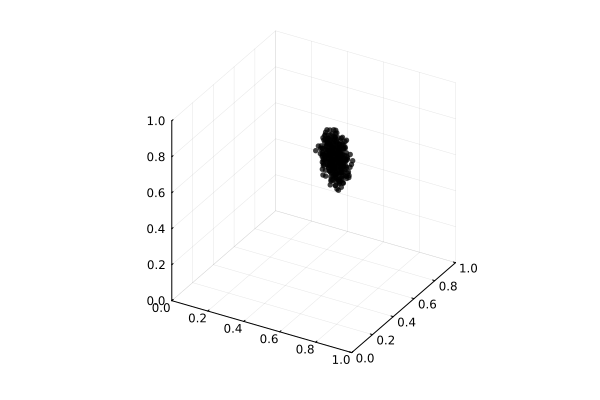

In [22]:
#lets grab a random window of data and visualise it
test_data = rand(test_set)
create_gif_from_raw(test_data)

In [23]:
function reconstruct(x) # x should be 60x900x1
    @assert(size(x) == (60,900,1))
    μ = encoder_μ(x)
    logσ = encoder_logvar(x)
    z = μ + cpu(randn(Float32, size(logσ))) .* exp.(logσ)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return reshape(x̂, 60,900)'
end

reconstruct (generic function with 1 method)

In [44]:
μ = encoder_μ(x)
logσ = encoder_logvar(x)
z = μ + cpu(randn(Float32, size(logσ))) .* exp.(logσ)
# Reconstruct from latent sample
x̂ = decoder(z)


60×900×1 Array{Float32, 3}:
[:, :, 1] =
 0.600133  0.577359  0.801425  0.667184  …  0.672783  0.445878  0.763654
 0.586368  0.570007  0.798048  0.662347     0.670865  0.436902  0.759144
 0.577935  0.568641  0.809281  0.667066     0.667156  0.420582  0.750359
 0.557903  0.557492  0.813223  0.659451     0.659001  0.416769  0.736637
 0.558718  0.570175  0.815316  0.655493     0.651706  0.414219  0.728758
 0.570227  0.575608  0.805717  0.6535    …  0.650317  0.415299  0.733824
 0.55376   0.574479  0.800552  0.653708     0.638592  0.412237  0.731047
 0.54371   0.580329  0.799512  0.635945     0.63699   0.409548  0.729316
 0.531334  0.577865  0.792927  0.632174     0.623669  0.394559  0.748062
 0.536908  0.586493  0.792292  0.639509     0.625248  0.401219  0.743089
 ⋮                                       ⋱                      
 0.245983  0.534982  0.71895   0.419283     0.442579  0.260011  0.630394
 0.23632   0.518631  0.722342  0.414251     0.443119  0.253991  0.621705
 0.241978  0.512662

In [46]:

denoise(x̂ .|> Float64)

([0.600132942199707 0.5773594379425049 … 0.44587796926498413 0.7636539936065674; 0.5863683819770813 0.5700070858001709 … 0.43690225481987 0.7591440081596375; … ; 0.21747928857803345 0.48025739192962646 … 0.240936279296875 0.599282443523407; 0.22850026190280914 0.46005845069885254 … 0.2406105101108551 0.5968050360679626;;;], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;])

┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
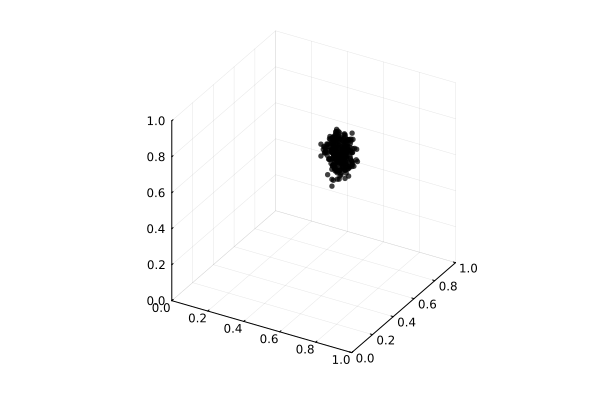

In [24]:
#now lets push that window through our autoencoder and visualise the reconstruction
x = getobs(Flux.unsqueeze(test_data', 3))
recon = reconstruct(x)

create_gif_from_raw(cpu(recon))

In [27]:
using KissSmoothing

┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
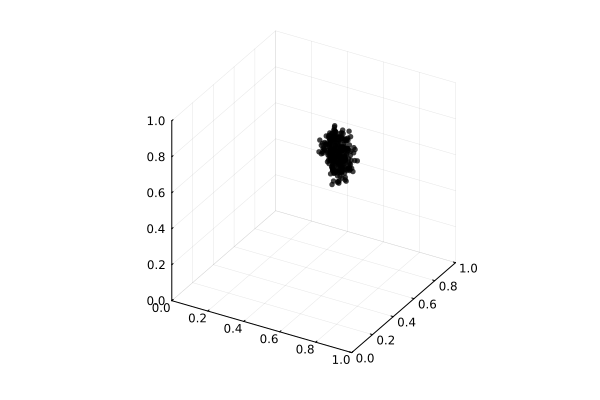

In [43]:
create_gif_from_raw(denoise(recon .|> Float64; factor=1.0)[1])

In [72]:
using Pkg
Pkg.add("Interact")

    Updating registry at `/opt/julia/registries/General`
   Resolving package versions...
   Installed CSSUtil ─────── v0.1.1
   Installed Knockout ────── v0.2.6
   Installed DataAPI ─────── v1.13.0
   Installed TimerOutputs ── v0.5.22
   Installed InteractBase ── v0.10.8
   Installed DiffRules ───── v1.12.1
   Installed Interact ────── v0.10.4
   Installed Distributions ─ v0.25.77
   Installed Observables ─── v0.4.0
    Updating `/notebooks/Project.toml`
  [c601a237] + Interact v0.10.4
    Updating `/notebooks/Manifest.toml`
  [70588ee8] + CSSUtil v0.1.1
  [9a962f9c] ↑ DataAPI v1.12.0 ⇒ v1.13.0
  [b552c78f] ↑ DiffRules v1.12.0 ⇒ v1.12.1
  [31c24e10] ↑ Distributions v0.25.76 ⇒ v0.25.77
  [c601a237] + Interact v0.10.4
  [d3863d7c] + InteractBase v0.10.8
  [bcebb21b] + Knockout v0.2.6
  [510215fc] ↓ Observables v0.5.4 ⇒ v0.4.0
  [a759f4b9] ↑ TimerOutputs v0.5.21 ⇒ v0.5.22
    Building Knockout ────→ `/opt/julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/91835de56d816864f1c38fb5e3

┌ Info: (Base.OneTo(60), Base.OneTo(900), Base.OneTo(1))
└ @ Main /Users/max/Swarm/notebooks/DCVAE2.ipynb:4


┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
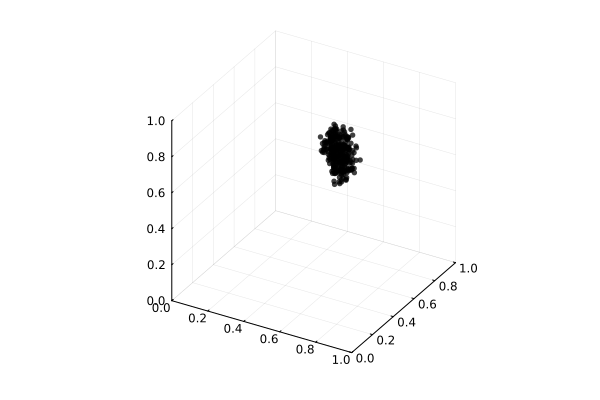

In [61]:
#z[1] = z[1] - 0.1
x̂ = (decoder |> cpu)(z)
#output = reshape(x̂, 60,900)'
@info axes(x̂)
#output = denoise(reshape(x̂, 60,900)' .|> Float64)[1]  .|> Float32
output = reshape(denoise(x̂ .|> Float64; dims=1)[1] .|> Float32, 60,900)'

create_gif_from_raw(output)

Plots.AnimatedGif("/notebooks/anim_fps30.gif")
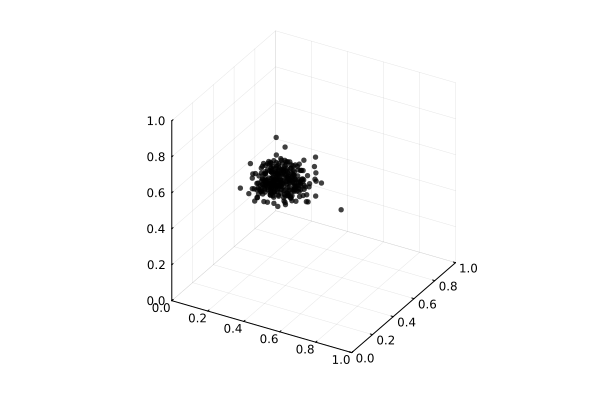

In [99]:
z = rand(100,1) * 20 .- 10 |> f32


Plots.AnimatedGif("/notebooks/anim_fps30.gif")
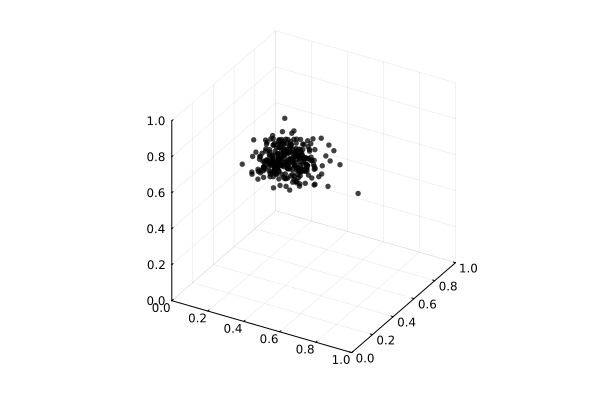

In [105]:
z[7] = -10
x̂ = (decoder |> cpu)(z)
output = reshape(x̂, 60,900)'
create_gif_from_raw(output)